# Assignment: forward kinematics of a Thymio
The provided dataset represents the motion from the two wheels of a thymio, as measured through a pretty inaccurate method based on the observed voltages of the two motors (i.e. not a wheel encoder).

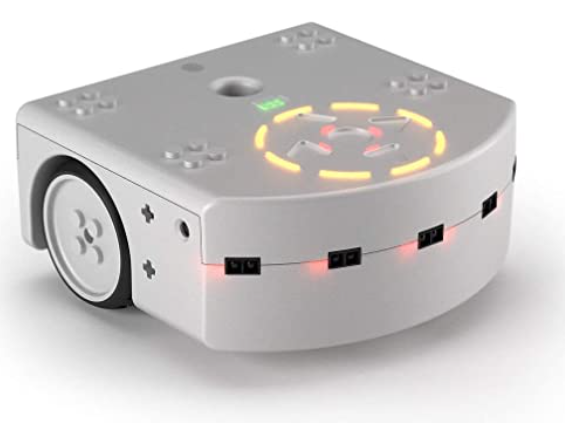

Each 0.1s, you get a reading that represents the total amount of rotation of the left and right wheels, since an arbitrary starting point in the past; the value corresponds to the total displacement, in meters, at the edge of each wheel (this already takes into account the wheel radius).

The distance between the wheels is $2l = 9.35$ cm.

## Data import

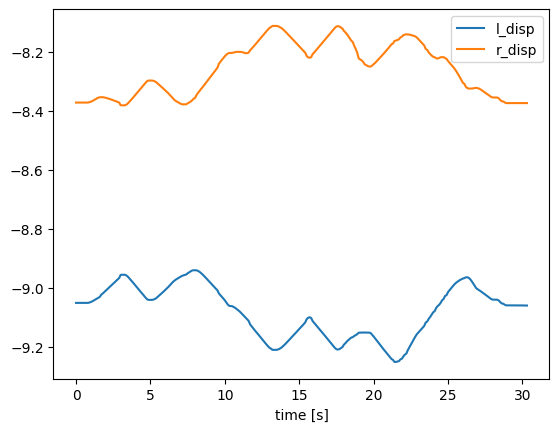

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("data.csv")
fig,ax = plt.subplots()
ax.plot(df["t"], df["l_disp"], label="l_disp")
ax.plot(df["t"], df["r_disp"], label="r_disp")
ax.set(xlabel = "time [s]")
ax.legend();

Observe that:
- When both lines move up, both wheels are moving forwards and the robot is advancing
- When both lines are horizontal, such as in the end, the robot is not moving
- The absolute values of each line do not matter, just their rates of change (that correspond to the tangential velocity of the wheels).

Let's now compute the tangential velocities of the two wheels, in m/s, and move to numpy arrays, that you might be more familiar with.

In [2]:
df[["l_vel","r_vel"]] = df[["l_disp","r_disp"]].diff(axis=0).fillna(0) / 0.1
l_vel, r_vel = df[["l_vel","r_vel"]].values.T
t = df["t"].values

You can now work with 1d numpy arrays `l_vel` (m/s), `r_vel` (m/s), `t` (s)

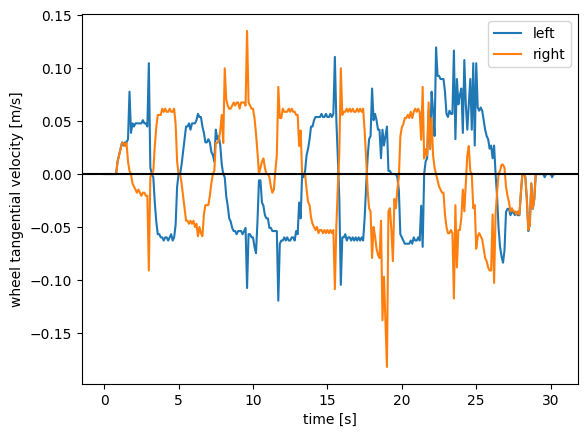

In [3]:
# Visualize to make sure the data is sane
fig,ax = plt.subplots()
ax.plot(t, l_vel, label="left")
ax.plot(t, r_vel, label="right")
ax.axhline(y=0, color="k")
ax.legend()
ax.set(xlabel="time [s]", ylabel="wheel tangential velocity [m/s]");

## Assignments

### 1: Compute and visualize the trajectory of the robot
This will require to implement the robot kinematics.
You can visualize the trajectory of the robot reference point as a line (note: you won't see the orientation of the robot!).

As a sanity check: the reference point of the robot moves within a small area (approximately $12 \times 10$ centimeters); the robot often turns in place, don't expect a long smooth trajectory.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:


def mktr(x, y):
    return np.array([[1, 0, x],
                     [0, 1, y],
                     [0, 0, 1]])


def mkrot(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [0,              0,             1]])

def drawf(f, ax=None, name=None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0, 0, 1], [1, 0, 1]]).T
    yhat = f @ np.array([[0, 0, 1], [0, 1, 1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0, :], xhat[1, :], 'r-')  # transformed x unit vector
    ax.plot(yhat[0, :], yhat[1, :], 'g-')  # transformed y unit vector
    if(name):
        ax.text(xhat[0, 0], xhat[1, 0], name, va="top", ha="center")

def drawrobot(f, l, ax=None, alpha=0.5,dummy_alpha = 1):
    """ Draw robot at f, with wheel distance from center l,
    on axis ax (if provided) or on plt.gca() otherwise.
    if l is None, no wheels are drawn"""

    if(not ax):
        ax = plt.gca()

    
    #robot = ([[-1, 2, -1, -1],  # x
    #          [-1, 0,  1, -1]])  # y
    
    robot = ([[0,1],  # x
              [0,0]])  # y
    
    robot = np.array(robot)
    robot = np.vstack((
        robot * 0.01,  # scale by 0.1 units
        np.ones((1, robot.shape[1]))))
    
    robott = f @ robot

    '''
    wheell = np.array([
        [-0.05, 0.05],
        [l, l],
        [1, 1]
    ])
    '''
    #wheelr = wheell * np.array([[1, -1, 1]]).T
    #wheellt = f @ wheell
    #wheelrt = f @ wheelr
    
    # plot a dot on ax
    ax.scatter(robott[0, 0], robott[1, 0],color='blue' if dummy_alpha==1 else 'orange',alpha=dummy_alpha)
    if dummy_alpha == 1:
        ax.plot(robott[0, :], robott[1, :], color='black', alpha=alpha)
    #ax.plot(wheellt[0, :], wheellt[1, :], 'k-', alpha=alpha)
    #ax.plot(wheelrt[0, :], wheelrt[1, :], 'k-', alpha=alpha)

(-0.05, 1.05, -0.05, 1.05)

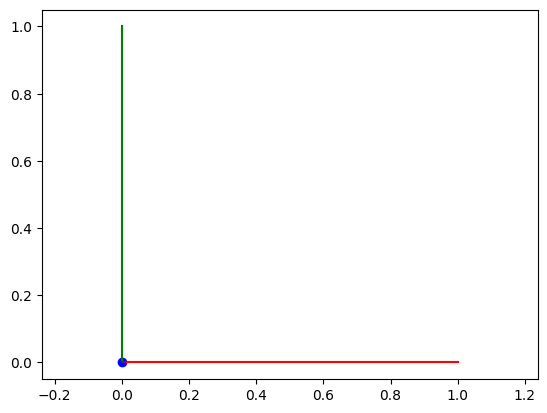

In [6]:
l = (9.35/2)*0.01 # conversion to meters
drawf(np.eye(3))
drawrobot(np.eye(3), l) 
#drawrobot(mktr(0.5, 0.3) @ mkrot(np.pi/4), 0.1)
plt.gca().axis("equal")

In [7]:
def ddtr(vl, vr, l, dt):
    """ returns the pose transform for a motion with duration dt of a differential
    drive robot with wheel speeds vl and vr and wheelbase l """

    if(np.isclose(vl, vr)):  # we are moving straight, R is at the infinity and we handle this case separately
        return mktr((vr + vl)/2*dt, 0)  # note we translate along x ()

    omega = (vr - vl) / (2 * l)  # angular speed of the robot frame
    R = l * (vr + vl) / (vr - vl)

    return mktr(0, R) @ mkrot(omega * dt) @ mktr(0, -R)

(-0.006232786344314717,
 0.13088851323060904,
 -0.119861285909474,
 0.0057111293614961365)

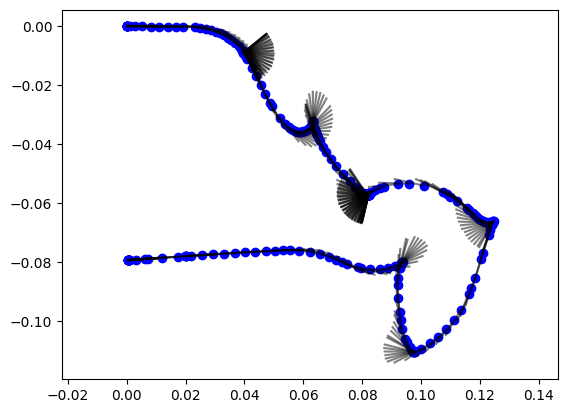

In [13]:
dt = 0.1
Ts = [np.eye(3)]

for i in range(df.shape[0] - 1):
    Ts.append(Ts[-1] @ ddtr(l_vel[i], r_vel[i], l, dt))
    
for T in Ts:
    drawrobot(T, l)
plt.axis("equal")

### 2: visualize the trajectory as an animation
Draw the robot and its orientation as a dot with a short line to indicate the direction it is facing.

To visualize the animation using matplotlib, have a look [here](https://matplotlib.org/stable/gallery/animation/simple_anim.html).

### 3: account for uncertainty
Also estimate the accumulating uncertainty of the robot pose (with respect to its initial pose).

As a cheap way to do so, implement a Monte Carlo approach.  Compute 100 replicas of the trajectory; in each, you can corrupt the displacement (or velocity) measured at each timestep with a multiplicative gaussian i.i.d noise $k \sim \mathcal{N}(\mu, \sigma^2)$ with $\mu = 1$ and $\sigma = 0.1$.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(-0.02712488824165267,
 0.14261749367582616,
 -0.12967550184483984,
 0.006417497025903539)

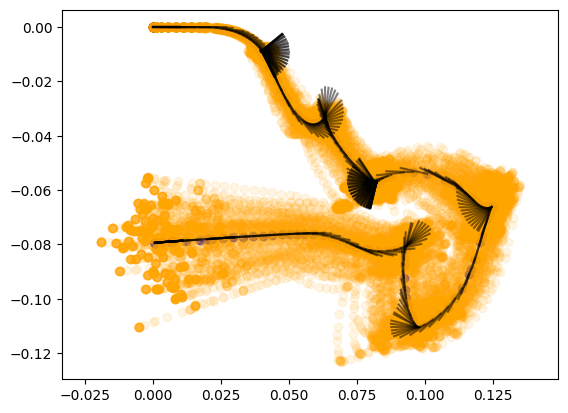

In [16]:
dt = 0.1
Ts = [np.eye(3)]

for i in range(df.shape[0] - 1):
    Ts.append(Ts[-1] @ ddtr(l_vel[i], r_vel[i], l, dt))
    
for T in Ts:
    drawrobot(T, l)

all_Ts = []
for i in range(100):
    Ts = [np.eye(3)]
    for i in range(df.shape[0] - 1):
        Ts.append(Ts[-1] @ ddtr(l_vel[i]*np.random.normal(1,0.1), r_vel[i]*np.random.normal(1,0.1), l, dt))
    all_Ts.append(Ts)

for ts in all_Ts:
    for T in ts:
        drawrobot(T, l, dummy_alpha=0.1)

plt.axis("equal")
    